# Set up

In [166]:
import requests
import json, os

nn_id = 'nn493999'  # put some key value you want to test

url = "{0}:{1}".format(os.environ['HOSTNAME'] , "8000")
print("done")

done


# Net & Version Create

In [167]:
####(1) 네트워크 생성 ####
resp = requests.post('http://' + url + '/api/v1/type/common/target/nninfo/nnid/' + nn_id + '/',
                     json={
                         "biz_cate": "MES",
                         "biz_sub_cate": "M60",
                         "nn_title" : "test",
                         "nn_desc": "test desc",
                         "use_flag" : "Y",
                         "dir": "purpose?",
                         "config": "N"
                     })
data = json.loads(resp.json())
print("evaluation result : {0}".format(data))

####(2) 버전 생성 ####
resp = requests.post('http://' + url + '/api/v1/type/common/target/nninfo/nnid/' + nn_id + '/version/',
                 json={
                     "nn_def_list_info_nn_id": "",
                     "nn_wf_ver_info": "test version info",
                     "condition": "1",
                     "active_flag": "Y"
                 })
data = json.loads(resp.json())
print("evaluation result : {0}".format(data))


evaluation result : nn493999
evaluation result : nn493999


# Graph Flow 정의
CSV 데이터를 AutoEncoder 에 훈련시키는 Graph Flow 정의, Eval Node 는 정의하지 않음. 

In [168]:
# Work Flow 틀을 구성하도로고 지시한다. (정해진 틀을 강제로 생성)
resp = requests.post('http://' + url + '/api/v1/type/wf/target/init/mode/simple/' + nn_id +'/wfver/1/',
                     json={
                         "type": 'autoencoder_csv'
                     })
data = json.loads(resp.json())
print("evaluation result : {0}".format(data))

evaluation result : autoencoder_csv


# CSV Data Upload 
한글 CSV 데이터를 업로드 한다. 

In [169]:
return_dict = {}
return_dict['test'] = open('../../data/Titanic.csv', 'rb')

resp = requests.post('http://' + url + '/api/v1/type/wf/state/framedata/src/local/form/raw/prg/source/nnid/'+nn_id+'/ver/1/node/datasrc/',
                     files = return_dict)

data = json.loads(resp.json())
print("evaluation result : {0}".format(data))

evaluation result : ['1 file upload success']


# Data Node 정의
데이터 처리에 관한 정의 CSV 파일을 Pandas 를 통해서 읽고 HDF5 로 변환, 별도의 전처리는 지정하지 않음 

In [170]:
# (1) Train Data Node 의 속성을 정의
# 어디서 Source 를 어떻게 가지고 올것인지 파라메터 정의 
resp = requests.put('http://' + url + '/api/v1/type/wf/state/framedata/src/local/form/raw/prg/source/nnid/'+nn_id+'/ver/1/node/datasrc/',
                     json={
                         "type": "csv",
                         "source_server": "local",
                         "source_sql": "all",
                     })

# 전처리는 어떤 것을 할지 정의
resp = requests.put('http://' + url + '/api/v1/type/wf/state/framedata/src/local/form/raw/prg/pre/nnid/'+nn_id+'/ver/1/node/datasrc/',
                      json={
                          "preprocess":  "none",
                      })
# 전처리가 완료된 데이터는 어디에 저장을 할지 
resp = requests.put('http://' + url + '/api/v1/type/wf/state/framedata/src/local/form/raw/prg/store/nnid/'+nn_id+'/ver/1/node/datasrc/',)

data = json.loads(resp.json())
print("evaluation result : {0}".format(data))

evaluation result : /hoya_str_root/nn493999/1/datasrc


# Data Feeder 
Network 에서 훈련을 위해 원하는 형태로 데이터를 편집하여 제공하는 기능 수행 

In [171]:
# (2) Network 에 데이터를 Feed하는 Node 의 속성을 정의 
resp = requests.post('http://' + url + '/api/v1/type/wf/state/pre/detail/feed/src/frame/net/autoencoder/nnid/'+nn_id+'/ver/1/node/feed_train/',
                     json={
                         "encode_column" : ["Class","Sex","Age","Survived","Freq"],
                         "vocab_size" : 100,
                         "preprocess": "frame",
                         "embed_type" : 'onehot'
                     })
data = json.loads(resp.json())
print("evaluation result : {0}".format(data))

evaluation result : {'vocab_size': 100, 'preprocess': 'frame', 'encode_column': ['Class', 'Sex', 'Age', 'Survived', 'Freq'], 'embed_type': 'onehot'}


# AutoEncoder 정의 
n_hidden 의 경우 Encoder 부만 정의하면 Decoder부는 동일한 Vector 를 Revsere로 활용하도록 되어 있다. 

In [172]:
resp = requests.put('http://' + url + '/api/v1/type/wf/state/netconf/detail/autoencoder/nnid/' + nn_id + '/ver/1/node/netconf_node/',
                     json={
                        "learning_rate" : 0.01,
                        "iter" : 10,
                        "batch_size" : 10,
                        "examples_to_show" : 10,
                        "n_hidden" : [200, 100] 
                     })
data = json.loads(resp.json())
print("evaluation result : {0}".format(data))

evaluation result : {'examples_to_show': 10, 'model_path': '/hoya_model_root/nn493999/1/netconf_node', 'learning_rate': 0.01, 'batch_size': 10, 'n_hidden': [200, 100], 'iter': 10}


# Eval Process Set

In [173]:
return_dict = {}
return_dict['test'] = open('../../data/Titanic.csv', 'rb')

resp = requests.post('http://' + url + '/api/v1/type/wf/state/framedata/src/local/form/raw/prg/source/nnid/'+nn_id+'/ver/1/node/evaldata/',
                     files = return_dict)

data = json.loads(resp.json())
print("evaluation result : {0}".format(data))

# 데이터 - 소스 정의
resp = requests.put('http://' + url + '/api/v1/type/wf/state/framedata/src/local/form/raw/prg/source/nnid/'+nn_id+'/ver/1/node/evaldata/',
                     json={
                         "type": "csv",
                         "source_server": "local",
                         "source_sql": "all",
                     })
data = json.loads(resp.json())
print("evaluation result : {0}".format(data))

# 데이터 - 전처리 정의
resp = requests.put('http://' + url + '/api/v1/type/wf/state/framedata/src/local/form/raw/prg/pre/nnid/'+nn_id+'/ver/1/node/evaldata/',
                      json={
                          "preprocess":  "none",
                      })
data = json.loads(resp.json())
print("evaluation result : {0}".format(data))

# 데이터 - 저장 정의
resp = requests.put('http://' + url + '/api/v1/type/wf/state/framedata/src/local/form/raw/prg/store/nnid/'+nn_id+'/ver/1/node/evaldata/',)

data = json.loads(resp.json())
print("evaluation result : {0}".format(data))


# Feeder 정의
resp = requests.post('http://' + url + '/api/v1/type/wf/state/pre/detail/feed/src/frame/net/autoencoder/nnid/'+nn_id+'/ver/1/node/feed_test/',
                     json={
                         "encode_column" : ["Class","Sex","Age","Survived","Freq"],
                         "vocab_size" : 100,
                         "preprocess": "frame",
                         "embed_type" : 'onehot'
                     })
data = json.loads(resp.json())
print("evaluation result : {0}".format(data))

node_name = 'eval_node'
resp = requests.put('http://' + url + '/api/v1/type/wf/state/eval/nnid/'+nn_id+'/ver/1/node/eval_node/',
                    json={
                        "type": "regression",
                    })

data = json.loads(resp.json())
print("evaluation result : {0}".format(data))

evaluation result : ['1 file upload success']
evaluation result : {'type': 'csv', 'source_type': 'local', 'max_sentence_len': 0, 'source_server': 'local', 'source_parse_type': 'raw', 'source_path': '/hoya_src_root/nn493999/1/evaldata', 'source_sql': 'all', 'multi_node_flag': None}
evaluation result : none
evaluation result : /hoya_str_root/nn493999/1/evaldata
evaluation result : {'vocab_size': 100, 'preprocess': 'frame', 'encode_column': ['Class', 'Sex', 'Age', 'Survived', 'Freq'], 'embed_type': 'onehot'}
evaluation result : {'type': 'regression'}


# Train 을 시작한다. 

In [185]:
# Run All Workflow
resp = requests.post('http://' + url + '/api/v1/type/runmanager/state/train/nnid/'+nn_id+'/ver/1/')
data = json.loads(resp.json())
print("evaluation result : {0}".format(data))

evaluation result : [None, None, None, None, 'nn493999_1_netconf_node', {'predicts': ['0.189445476358', '0.249092561295', '0.143620457554', '0.185858761533', '0.139770175389', '0.202310995395', '0.152413285618', '0.156967461166', '0.135706966032', '0.13609078445', '0.134945311795', '0.134872916749', '0.164857404046', '0.153979396494', '0.13603959381', '0.171819232956', '0.165583558673', '0.157816825006', '0.154235051665', '0.172818318713', '0.231994565452', '0.159238673587', '0.151681602482', '0.172640329364', '0.135322102844', '0.145937387842', '0.135798617051', '0.135214231049', '0.135345693724', '0.137259333981', '0.135985902793', '0.135960087873'], 'labels': ['0.1', '0.1', '0.1', '0.1', '0.1', '0.1', '0.1', '0.1', '0.1', '0.1', '0.1', '0.1', '0.1', '0.1', '0.1', '0.1', '0.1', '0.1', '0.1', '0.1', '0.1', '0.1', '0.1', '0.1', '0.1', '0.1', '0.1', '0.1', '0.1', '0.1', '0.1', '0.1']}]


# Graph

{'predicts': ['0.189445476358', '0.249092561295', '0.143620457554', '0.185858761533', '0.139770175389', '0.202310995395', '0.152413285618', '0.156967461166', '0.135706966032', '0.13609078445', '0.134945311795', '0.134872916749', '0.164857404046', '0.153979396494', '0.13603959381', '0.171819232956', '0.165583558673', '0.157816825006', '0.154235051665', '0.172818318713', '0.231994565452', '0.159238673587', '0.151681602482', '0.172640329364', '0.135322102844', '0.145937387842', '0.135798617051', '0.135214231049', '0.135345693724', '0.137259333981', '0.135985902793', '0.135960087873'], 'labels': ['0.1', '0.1', '0.1', '0.1', '0.1', '0.1', '0.1', '0.1', '0.1', '0.1', '0.1', '0.1', '0.1', '0.1', '0.1', '0.1', '0.1', '0.1', '0.1', '0.1', '0.1', '0.1', '0.1', '0.1', '0.1', '0.1', '0.1', '0.1', '0.1', '0.1', '0.1', '0.1']}


<IPython.core.display.Javascript object>


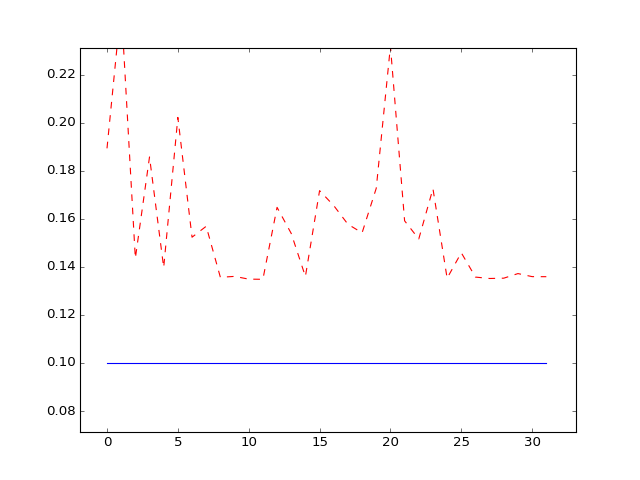

In [192]:
%matplotlib notebook

import matplotlib.pyplot as plt
import numpy as np

resp = requests.get('http://' + url + '/api/v1/type/result/nnid/' + nn_id + '/ver/1/')
data = json.loads(resp.json())
print(data)
x=range(len(data.get('labels')))
y=data.get('labels')
y_y=data.get('predicts')

plt.plot(x,y, 'b-',x, y_y,'r--')
plt.show()

# Compressed Vector 를 구해보자 
해당 Vector 의 Size 는 "n_hidden" : [200, 100, 10]에서 정의한 마지막 Layer 의 사이즈가 될 것이다. 

In [160]:
#["Class","Sex","Age","Survived","Freq"]
#"1","1st","Male","Child","No",0
resp = requests.post('http://' + url + '/api/v1/type/service/state/predict/type/anomaly/nnid/'+nn_id+'/ver/active/',
                     json={"input_data" : {"Class":1,
                                           "Sex":1,
                                           "Age":1,
                                           "Survived":1,
                                           "Freq":1} }
                     )
data = json.loads(resp.json())
print("evaluation result : {0}".format(data)) 

resp = requests.post('http://' + url + '/api/v1/type/service/state/predict/type/anomaly/nnid/'+nn_id+'/ver/active/',
                     json={"input_data" : {"Class":'1st',
                                           "Sex":'Male',
                                           "Age":'Child',
                                           "Survived":'No',
                                           "Freq":0} }
                     )
data = json.loads(resp.json())
print("evaluation result : {0}".format(data)) 

evaluation result : 0.12371374131080837
evaluation result : 0.14260566700800503
